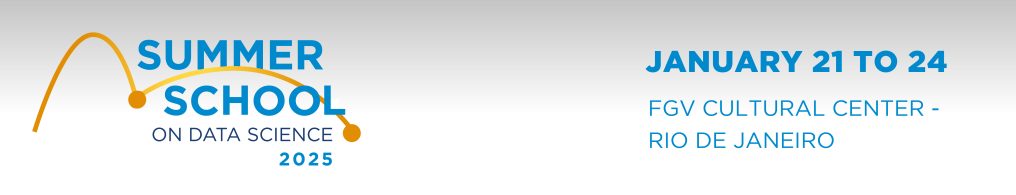

# FGV Summer School 2025
## Recommender Systems class 5 - Latent Factor Models

Diego Galeano, Ph.D.

$\color{green}{\text{Before starting}}$ let's run the following cell to have all the required libraries for this notebook.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import random
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

# If you want to have direct access to the datasets and codes you can clone the following github repository
! git clone https://github.com/saminehbagheri/Recommender-System.git
%cd Recommender-System

Cloning into 'Recommender-System'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66 (from 1)
Receiving objects: 100% (66/66), 347.53 KiB | 3.28 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/Recommender-System


Read the Movielens dataset

In [ ]:
mat = scipy.io.loadmat('ex8_movies.mat')
movie_names = pd.read_csv('movie_ids.txt',delimiter=';',header=None)[1]
R = mat['Y']

### Ranking-based RecSys (Top-N recommender systems)



*   Explicit-feedback dataset: when rating values are provided
*   Implicit-feedback dataset: no rating values, only binary.

Recommended lecture: Cremonesi et al.,  Performance of recommender algorithms on top-n recommendation tasks

In [ ]:
R_df = pd.DataFrame(R.T, columns=movie_names)

# Method 1: Truncated Singular Value Decomposition (pureSVD)

In [ ]:
U, S, V = np.linalg.svd(R_df.values, full_matrices=True)
D = np.zeros(shape=(U.shape[0], V.shape[0]))
D[0:U.shape[0], 0:U.shape[0]] = np.diag(S)

In [ ]:
k= 10
Uk = U[:, 0:k]
Dk = D[0:k, 0:k]
Vk = V[0:k, :]

print('Full SVD', U.shape, D.shape, V.shape)
print('tSVD', Uk.shape, Dk.shape, Vk.shape)

Full SVD (943, 943) (943, 1682) (1682, 1682)
tSVD (943, 10) (10, 10) (10, 1682)


In [ ]:
R_hat = pd.DataFrame(np.dot(np.dot(Uk, Dk), Vk), columns=movie_names)

## Matrix Factorization: Collaborative Filtering

Revisiting content-based recommendation systems, the main idea was to describe each item and each user with a vector of significant features. In our example from the previous class, the feature vector we used had only three elements. However, we recognize that there are far more important criteria than those three to capture our interest in a movie, and sometimes these features can be more complex than simply the genre of the movie.

Matrix Factorization assumes that we can represent a movie and a user as feature vectors. The primary idea behind matrix factorization is to find the user feature vector $ \vec{x}_i $ and the item feature vector $ \vec{\theta}_j $ for all users $ i = 1 \cdots n_u $ and movies $ j = 1 \cdots n_m $ such that their dot products provide a good estimate of the rating that the $ i $-th user would give to the $ j $-th movie $ y_{ij} $.

**Why is this method called matrix decomposition?**  
It is called matrix decomposition because the rating a user gives to a movie is modeled as the dot product between the user's feature vector and the movie's feature vector, i.e., $\vec{x}_i\cdot\vec{\theta}_j=y_{ij}$. Suppose we stack all the user feature vectors into a user feature matrix $\mathbf{X}=\begin{bmatrix}-\vec{x}_1^T-\\ -\vec{x}_2^T- \\ \vdots \\-\vec{x}_{n_u}^T- \end{bmatrix}_{n_u \times n_f}$ and all the movie feature vectors into a movie feature matrix $\mathbf{\Theta}=\begin{bmatrix}-\vec{\theta}_1^T-\\ -\vec{\theta}_2^T- \\ \vdots \\-\vec{\theta}_{n_m}^T- \end{bmatrix}_{n_m \times n_f}$. Then, the rating matrix can be determined as follows:

\begin{equation}\mathbf{\Theta} \cdot \mathbf{X}^T\simeq\mathbf{R}\end{equation}
\begin{equation}\begin{bmatrix}- \vec{\theta}_1^T-\\ - \vec{\theta}_2^T- \\ \vdots \\- \vec{\theta}_{n_m}^T- \end{bmatrix} \cdot \begin{bmatrix}|&|&\cdots&|\\
               \vec{x_1}&\vec{x_2}&\cdots&\vec{x}_{n_u}\\
               |&|&\cdots&|\end{bmatrix}\simeq\mathbf{R}\end{equation}

It would be ideal if we had the proper feature matrices, but we don’t. What we actually have is the rating matrix $ \mathbf{Y}$, and we attempt to *learn* the feature matrices from $ \mathbf{Y}$. The name **matrix factorization** stems from the fact that this algorithm aims to find reasonably optimal feature matrices by factorizing the rating matrix $ \mathbf{Y}$.

**How does matrix factorization work?**  
Suppose we initialize the feature matrices with completely random values. The dot product of the $ i$-th user's feature vector and the $ j $-th movie's feature vector would yield $ p_{ij} $, which is likely far from the actual rating $ y_{ij} $. The goal is to find the feature matrices such that the error $ | p_{ij} -y_{ij} | $ is minimized for all given ratings. In other words, matrix factorization becomes an optimization problem to minimize a cost function that is the sum of all the $ \color {green}{\text{squared}} $ errors for all cells with a rating. The cost function to minimize is defined as follows:


\begin{equation}J(\mathbf{\Theta},\mathbf{X})=\frac{1}{2} \sum\limits_{(i,j):r(i,j)=\{1\}} (\vec{\theta}_{j} \vec{x}_{i}-y_{i,j})^2\end{equation}


**How to solve such an optimization problem?**  
We could pass the cost function with a random starting point to an optimizer and wait for it to find an optimal solution. However, this would take an unbearably long time since the optimization problem is extremely high-dimensional. Can you guess the input dimension of this optimization problem? $ (n_u + n_m) * n_f $, where $ n_f $ is the number of features.

A more logical approach is to calculate the gradients iteratively toward the optimal solution using gradient descent or conjugate gradient methods. Calculating the gradients is straightforward because our cost function is a quadratic function.

## The Gradients

 \begin{equation}\frac{\partial J}{\partial x_i^{(k)}}=\sum\limits_{j:r(i,j)=1}(\vec{\theta}_{j} \vec{x}_{i}-y_{i,j})\theta^{(k)}_j,\end{equation}
 \begin{equation}\frac{\partial J}{\partial \theta_j^{(k)}}=\sum\limits_{i:r(i,j)=1}(\vec{\theta}_{j} \vec{x}_{i}-y_{i,j})x^{(k)}_i,\end{equation}


where $x^{(k)}_j$ is the $k$-th element of the $i$-th user's feature vector $\vec{x}_i$.

The main steps of the matrix factorization algorithm can be summarized as follows:

1. Initialize $ \mathbf{\Theta} $ and $ \mathbf{X} $ with small random numbers.
2. Minimize the cost function $ J (\mathbf{\Theta}, \mathbf{X}) $.
3. Use the optimized feature matrices to predict.

## Step 1: Initialize parameters

In [ ]:
def initialize_features(num_users, num_items, num_features, seed=42):
    """
    Initializes the feature matrices for users and items.

    Args:
        num_users (int): Number of users.
        num_items (int): Number of items (e.g., movies).
        num_features (int): Number of latent features.
        seed (int, optional): Random seed for reproducibility. Default is 42.

    Returns:
        tuple:
            - item_features (numpy.ndarray): Feature matrix for items, with shape (num_items, num_features).
            - user_features (numpy.ndarray): Feature matrix for users, with shape (num_users, num_features).
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Initialize the feature matrix for items with small random values
    item_features = np.random.rand(num_items, num_features) * 0.05

    # Initialize the feature matrix for users with small random values
    user_features = np.random.rand(num_users, num_features) * 0.05

    return item_features, user_features


In [ ]:
X, Theta = initialize_features(2000, 5000, 10,seed=42)

print(X.shape)

(5000, 10)


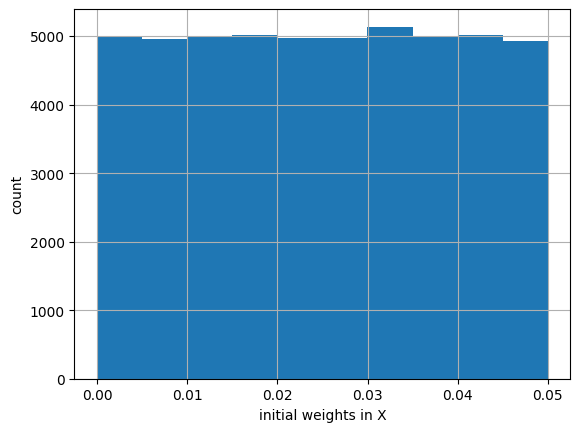

In [ ]:
plt.hist(X.flatten())
plt.xlabel('initial weights in X')
plt.ylabel('count')
plt.grid(True)

## Auxiliary functions

In [ ]:
import numpy as np

def flatten_to_matrices(flat_vector, num_users, num_items, num_features):
    """
    Converts a 1D vector into the feature matrices for items and users.

    Args:
        flat_vector (numpy.ndarray): A 1D vector containing the flattened features of items and users.
        num_users (int): Number of users.
        num_items (int): Number of items.
        num_features (int): Number of latent features.

    Returns:
        tuple:
            - item_features (numpy.ndarray): Matrix of item features with shape (num_items, num_features).
            - user_features (numpy.ndarray): Matrix of user features with shape (num_users, num_features).
    """
    # Extract and reshape item features from the first part of the vector
    item_features = flat_vector[:num_items * num_features].reshape((num_items, num_features), order='F')

    # Extract and reshape user features from the remaining part of the vector
    user_features = flat_vector[num_items * num_features:].reshape((num_users, num_features), order='F')

    return item_features, user_features


def flatten_to_vector(item_features, user_features):
    """
    Converts the feature matrices for items and users into a single 1D vector.

    Args:
        item_features (numpy.ndarray): Matrix of item features with shape (num_items, num_features).
        user_features (numpy.ndarray): Matrix of user features with shape (num_users, num_features).

    Returns:
        numpy.ndarray: A flattened 1D vector containing all the features of items and users.
    """
    # Flatten the item and user feature matrices column-wise and concatenate them into a single vector
    flat_vector = np.concatenate([
        item_features.reshape(item_features.size, order='F'),
        user_features.reshape(user_features.size, order='F')
    ])

    return flat_vector

## Loss function

In [ ]:

def compute_cost(item_features, user_features, ratings, mask, regularization=0):
    """
    Helper function to compute the cost for matrix factorization.

    Args:
        item_features (numpy.ndarray): Matrix of item features (shape: num_items x num_features).
        user_features (numpy.ndarray): Matrix of user features (shape: num_users x num_features).
        ratings (numpy.ndarray): Matrix of observed ratings (shape: num_users x num_items).
        mask (numpy.ndarray): Boolean mask where True indicates missing ratings.
        regularization (float, optional): Regularization parameter for L2 regularization. Default is 0.

    Returns:
        float: Computed cost normalized by the number of observed ratings.
    """
    # Apply mask to exclude missing ratings
    ratings_masked = np.ma.array(ratings, mask=mask)

    # Compute the prediction error
    prediction_error = np.dot(user_features, item_features.T) - ratings_masked

    # Compute the squared error cost
    cost = 0.5 * np.sum(np.power(prediction_error, 2))

    # Add L2 regularization terms
    cost += 0.5 * regularization * (np.sum(np.power(user_features, 2)) + np.sum(np.power(item_features, 2)))

    # Normalize cost by the number of observed ratings
    num_observed = np.sum(~mask)
    return cost / num_observed


def collaborative_filtering_cost(flat_vector, ratings, mask, num_users, num_items, num_features, regularization=0):
    """
    Computes the cost function with regularization for collaborative filtering.

    Args:
        flat_vector (numpy.ndarray): Flattened 1D vector containing item and user features.
        ratings (numpy.ndarray): Matrix of observed ratings (shape: num_users x num_items).
        mask (numpy.ndarray): Boolean mask where True indicates missing ratings.
        num_users (int): Number of users.
        num_items (int): Number of items.
        num_features (int): Number of latent features.
        regularization (float, optional): Regularization parameter for L2 regularization. Default is 0.

    Returns:
        float: Computed cost for the collaborative filtering model.
    """
    # Unpack the flattened vector into item and user feature matrices
    item_features, user_features = flatten_to_matrices(flat_vector, num_users, num_items, num_features)

    # Compute the cost using the helper function
    return compute_cost(item_features, user_features, ratings, mask, regularization=regularization)

## Gradients


In [ ]:
def compute_gradients(flat_vector, ratings, mask, num_users, num_items, num_features, regularization=0):
    """
    Computes the gradients of the cost function for matrix factorization.

    Args:
        flat_vector (numpy.ndarray): Flattened 1D vector containing item and user features.
        ratings (numpy.ndarray): Matrix of observed ratings (shape: num_users x num_items).
        mask (numpy.ndarray): Boolean mask where True indicates missing ratings.
        num_users (int): Number of users.
        num_items (int): Number of items.
        num_features (int): Number of latent features.
        regularization (float, optional): Regularization parameter for L2 regularization. Default is 0.

    Returns:
        numpy.ndarray: Flattened 1D vector of gradients for optimization.
    """
    # Unpack the flattened vector into item and user feature matrices
    item_features, user_features = flatten_to_matrices(flat_vector, num_users, num_items, num_features)

    # Apply mask to exclude missing ratings
    ratings_masked = np.ma.array(ratings, mask=mask)

    # Compute the error matrix
    prediction_error = np.dot(user_features, item_features.T) - ratings_masked

    # Compute gradients for user features and item features
    user_gradients = np.dot(prediction_error, item_features) + regularization * user_features
    item_gradients = np.dot(prediction_error.T, user_features) + regularization * item_features

    # Flatten gradients and combine into a single vector
    gradients = np.concatenate([
        item_gradients.reshape(item_gradients.size, order='F'),
        user_gradients.reshape(user_gradients.size, order='F')
    ])

    # Normalize gradients by the number of observed ratings
    num_observed = np.sum(~mask)
    return gradients / num_observed


### Training function

The training function is actually just applying an optimization algorithm on the cost function. We use a built-in conjugate gradient optimizer from the scipy library. You may want to try different methods.

In [ ]:
def train_matrix_factorization(ratings, mask, num_features, regularization=0, seed=42):
    """
    Trains a matrix factorization model using collaborative filtering and gradient descent.

    Args:
        ratings (numpy.ndarray): User-item ratings matrix (shape: num_users x num_items).
        mask (numpy.ndarray): Boolean mask where True indicates missing ratings.
        num_features (int): Number of latent features for the model.
        regularization (float, optional): Regularization parameter for L2 regularization. Default is 0.
        seed (int, optional): Seed for random number generation. Default is 42.

    Returns:
        tuple:
            - float: Mean squared error (MSE) of the trained model on observed ratings.
            - OptimizeResult: Result object from the optimizer containing learned parameters.
            - int: Number of users.
            - int: Number of items.
            - int: Number of latent features.
    """
    # Extract the number of users and items
    num_users = ratings.shape[0]
    num_items = ratings.shape[1]

    # Mask missing ratings in the ratings matrix
    ratings_masked = np.ma.array(ratings, mask=mask)

    # Initialize feature matrices for users and items
    item_features, user_features = initialize_features(num_users, num_items, num_features, seed=seed)

    # Flatten the feature matrices into a single 1D vector
    flat_parameters = flatten_to_vector(item_features, user_features)

    # Minimize the cost function using the Conjugate Gradient (CG) method
    optimization_result = minimize(
        fun=collaborative_filtering_cost,
        x0=flat_parameters,
        args=(ratings_masked, mask, num_users, num_items, num_features, regularization),
        method='CG',
        jac=compute_gradients,
        options={'disp': True, 'gtol': 1e-5}
    )

    # Calculate the mean squared error (MSE) for the optimized parameters
    final_mse = collaborative_filtering_cost(
        optimization_result.x, ratings_masked, mask, num_users, num_items, num_features, regularization
    )

    return final_mse, optimization_result, num_users, num_items, num_features

### Prediction function

In [ ]:
def predict_ratings(optimized_result, num_users, num_items, num_features):
    """
    Generates predicted ratings for all user-item pairs using the trained model.

    Args:
        optimized_result (OptimizeResult): Optimization result containing the flattened feature matrices.
        num_users (int): Number of users.
        num_items (int): Number of items.
        num_features (int): Number of latent features.

    Returns:
        numpy.ndarray: Predicted ratings matrix (shape: num_users x num_items).
    """
    # Recover user and item feature matrices from the optimization result
    item_features, user_features = flatten_to_matrices(optimized_result.x, num_users, num_items, num_features)

    # Compute the predicted ratings as the dot product of user and item feature matrices
    predicted_ratings = np.dot(user_features, item_features.T)

    return predicted_ratings


# Building our recommender systems

In [ ]:
def build_recommendation_model(ratings, mask, user_means=None, num_features=10, reg_lambda=0, seed=42, movie_names=None):
    """
    Builds a recommendation system model using matrix factorization.

    Args:
        ratings (numpy.ndarray): Matrix of user-item ratings.
        mask (numpy.ndarray): Mask matrix indicating missing ratings (1 = missing, 0 = observed).
        user_means (numpy.ndarray, optional): Mean rating for each user. If None, it is computed from the data.
        num_features (int): Number of latent features to use in the factorization.
        reg_lambda (float): Regularization parameter for L2 regularization.
        seed (int): Random seed for reproducibility.
        movie_names (list, optional): List of movie names corresponding to the items.

    Returns:
        dict: A dictionary containing the trained model and associated metadata.
    """
    # Copy ratings and mask to avoid modifying the originals
    train_ratings = copy.copy(ratings)
    train_mask = copy.copy(mask)

    # Mask the training ratings matrix
    train_ratings = np.ma.array(train_ratings, mask=train_mask)

    # Compute user means if not provided
    if user_means is None:
        user_means = np.average(train_ratings, axis=1)

    # Normalize ratings by subtracting user means
    train_ratings = train_ratings - user_means[:, None]

    # Train the matrix factorization model
    training_error, optimization_result, num_users, num_items, num_features = train_matrix_factorization(train_ratings, train_mask, num_features, reg_lambda, seed)

    # Build the model dictionary
    model = {
        'training_error': training_error,
        'optimization_result': optimization_result,
        'num_users': num_users,
        'num_items': num_items,
        'num_features': num_features,
        'reg_lambda': reg_lambda,
        'movie_names': movie_names,
        'user_means': user_means,
        'ratings': ratings,
        'mask': mask,
    }

    return model



Train the model

In [ ]:
R.shape

(1682, 943)

In [ ]:
train_ratings = copy.copy(R)
train_mask = (R == 0)  # Create a boolean mask for missing ratings
# Build the recommendation system model
my_model = build_recommendation_model(
      ratings=train_ratings,
      mask=train_mask,
      user_means=None,
      num_features=250,
      reg_lambda=10,
      seed=42,
      movie_names=movie_names,
)


         Current function value: 0.368347
         Iterations: 16
         Function evaluations: 211
         Gradient evaluations: 199


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### Predict for a given user

In [ ]:

def predict_for_user(user_id, model, movie_id=None):
    """
    Predicts movie ratings for a specific user using the trained recommendation model.

    Args:
        user_id (int): ID of the user for whom predictions are made.
        model (dict): Trained recommendation model returned by `build_recommendation_model`.
        movie_id (int, optional): Specific movie ID to get predictions for. If None, predictions are made for all movies.

    Returns:
        pandas.DataFrame: DataFrame containing movie names, predicted ratings, and original ratings, sorted by predicted ratings.
    """
    # Extract model parameters
    training_error = model['training_error']
    res = model['optimization_result']
    num_users = model['num_users']
    num_items = model['num_items']
    num_features = model['num_features']
    reg_lambda = model['reg_lambda']
    movie_names = model['movie_names']
    user_means = model['user_means']
    ratings_matrix = model['ratings']
    mask = model['mask']

    # Generate predictions using the trained model
    predicted_ratings_matrix = predict_ratings(res, num_users, num_items, num_features)

    # Prepare prediction data for the specified user
    user_predictions = predicted_ratings_matrix[:, user_id] + user_means[user_id]

    # Create a DataFrame with predictions and original ratings
    prediction_data = pd.DataFrame({
        'Movie Name': movie_names,
        'Predicted Rating': user_predictions,
        'Original Rating': ratings_matrix[:, user_id],
    })

    # Sort predictions in descending order by predicted rating
    prediction_data = prediction_data.sort_values(by='Predicted Rating', ascending=False)

    # If a specific movie ID is provided, filter for that movie
    if movie_id is not None:
        prediction_data = prediction_data[prediction_data.index == movie_id]

    return prediction_data


In [ ]:
# Specify user ID for prediction
user_id = 125

# Generate and display the top 10 predictions for the user
predictions = predict_for_user(user_id, my_model, None)
print(predictions.head(10))

                              Movie Name  Predicted Rating  Original Rating
242                  Jungle2Jungle(1997)          4.259087                5
265             Kull the Conqueror(1997)          4.112650                5
327              Conspiracy Theory(1997)          4.099353                5
339                  Boogie Nights(1997)          4.087182                5
679             Kull the Conqueror(1997)          4.050640                0
877                 That Darn Cat!(1997)          4.042964                5
298                        Hoodlum(1997)          4.013385                0
680                     Wishmaster(1997)          4.000199                5
221       Star Trek: First Contact(1996)          3.999805                0
987  Beautician and the Beast  The(1997)          3.992599                0


<ipython-input-75-9eec0ee0a93b>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


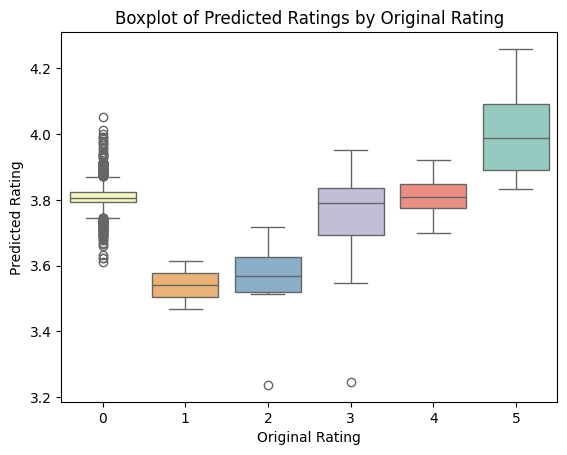

In [ ]:
def plot_with_colors(predictions):
    """
    Creates a boxplot with different colors for each 'Original Rating' category.

    Args:
        predictions (pd.DataFrame): DataFrame containing 'Original Rating' and 'Predicted Rating'.
    """
    # Ensure the 'Original Rating' column is consistent in type
    predictions['Original Rating'] = predictions['Original Rating'].astype(str)

    # Generate a unique color palette based on the unique values in 'Original Rating'
    unique_ratings = predictions['Original Rating'].unique()
    palette = sns.color_palette("Set3", len(unique_ratings))

    # Create a mapping dictionary for the palette
    palette_dict = dict(zip(unique_ratings, palette))

    # Create the boxplot with the color palette
    sns.boxplot(
        data=predictions,
        x='Original Rating',
        y='Predicted Rating',
        palette=palette_dict,
        order=[str(i) for i in range(6)]  # Explicitly order x-axis from 0 to 5
    )

    # Add labels and title
    plt.xlabel("Original Rating")
    plt.ylabel("Predicted Rating")
    plt.title("Boxplot of Predicted Ratings by Original Rating")
    plt.show()

plot_with_colors(predictions)